In [439]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns

pd.set_option('display.max_columns', None)

In [440]:
shot_metrics_df = pd.read_csv("shot_metric_df.csv")
shot_metrics_df.head()

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   
1           1  3c527d7b-6932-4190-8424-d1d3dcdd6a4d        191.0     1.0   
2           2  157da96f-2535-42f1-aaa4-273dc8ae2f12        368.0     1.0   
3           3  6a0404a3-2dd6-44d2-8c70-15bb2f858b82        535.0     1.0   
4           4  c06abd5a-b096-47eb-8352-6a5470db6d83        629.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   
1  00:05:11.529     5.0    11.0        11.0  1.023995       0.000000   
2  00:10:51.930    10.0    51.0        21.0  0.363535       0.000000   
3  00:14:17.334    14.0    17.0        27.0  1.067938       0.000000   
4  00:17:42.690    17.0    42.0        30.0  0.687717       0.047946   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   
1        0.034124    -0.034124           0.009421            0.009421   
2        0.204285    -0.204285           0.006885            0.006885   
3        0.095475    -0.095475           0.008562            0.008562   
4        0.076592    -0.028646           0.008465            0.008465   

   obv_against_net  obv_total_net under_pressure  type_id type_name  \
0              0.0       0.027997           True     16.0      Shot   
1              0.0      -0.034124            NaN     16.0      Shot   
2              0.0      -0.204285            NaN     16.0      Shot   
3              0.0      -0.095475            NaN     16.0      Shot   
4              0.0      -0.028646            NaN     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   
1                36.0      Manchester City              7.0    From Goal Kick   
2                36.0      Manchester City              3.0    From Free Kick   
3                34.0              Burnley              4.0     From Throw In   
4                34.0              Burnley              3.0    From Free Kick   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   
1     36.0  Manchester City        88.4        46.0        0.00   
2     36.0  Manchester City       114.7        46.6        1.08   
3     34.0          Burnley       104.7        31.0        0.00   
4     34.0          Burnley       107.2        26.6        0.00   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   
1               207b5c5a-ff48-4534-a5e2-0f83b20df80a     3089.0   
2               764d5d53-f1a1-4d37-9f78-b549101782c5    23616.0   
3               200cd1f9-50d7-4e73-9143-106f764722f8   256682.0   
4               8ebcd607-df4e-495e-8062-9cbf005d4fdf    48335.0   

            player_name  position_id          position_name  statsbomb_xg  \
0         Erling Håland         23.0         Center Forward      0.166126   
1       Kevin De Bruyne         13.0  Right Center Midfield      0.023693   
2         Erling Håland         23.0         Center Forward      0.142146   
3         Luca Koleosho         17.0             Right Wing      0.083945   
4  Mohamed Zeki Amdouni         23.0         Center Forward      0.085442   

   goal  penalty   body_part  opposition_in_triangle   gameId  match_date  \
0   1.0      0.0   Left Foot                     1.0  3892755  2023-08-11   
1   0.0      0.0  Right Foot                     2.0  3892755  2023-08-11   
2   0.0      0.0  Right Foot                     1.0  3892755  2023-08-11   
3   0.0      0.0  Right Foot                     1.0  3892755  2023-08-11   
4   0.0      0.0   Left Foot                     1.0  3892755  2023-08-11   

   Count HI_now  Count HI_ha

In [441]:
#good_shooters = shot_metrics_df[["player_id","statsbomb_xg"]].groupby("player_id",as_index=False).count().sort_values(by="statsbomb_xg", ascending=False)
#good_shooters = good_shooters[good_shooters["statsbomb_xg"]>99]
#shot_metrics_df =  shot_metrics_df[shot_metrics_df["player_id"].isin(good_shooters.player_id)]

In [442]:
shot_metrics_df["over_xg"] = shot_metrics_df["goal"]  - shot_metrics_df["statsbomb_xg"] 

In [443]:
shot_metrics_df["age"]= (pd.to_datetime(shot_metrics_df["match_date"])-pd.to_datetime(shot_metrics_df["birth_date"]))/pd.Timedelta(days=365.25)
shot_metrics_df["age"]= shot_metrics_df["age"].astype(int)

<Axes: ylabel='Density'>

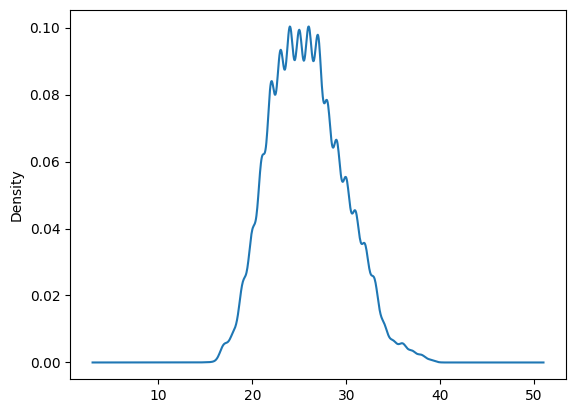

In [444]:
shot_metrics_df["age"].plot.density()

In [445]:

variable_list = [
    "High Intensity (HI) Distance_now", "High Intensity (HI) Distance_half", "High Intensity (HI) Distance_game", 
    "High Speed Running (HSR) Distance_now", "High Speed Running (HSR) Distance_half", "High Speed Running (HSR) Distance_game", 
    "Running Distance_now", "Running Distance_half", "Running Distance_game", 
    "Sprinting Distance_now", "Sprinting Distance_half", "Sprinting Distance_game", 
    "Total Distance_now", "Total Distance_half", "Total Distance_game", 
    "Count HI_1_week", "Count HSR_1_week", "Count High Acceleration_1_week", "Count High Deceleration_1_week", 
    "Count Medium Acceleration_1_week", "Count Medium Deceleration_1_week", "Count Sprint_1_week", 
    "High Intensity (HI) Distance_1_week", "High Speed Running (HSR) Distance_1_week", "M/min_1_week", 
    "Max Speed_1_week", "Running Distance_1_week", "Sprinting Distance_1_week", "Total Distance_1_week", 
    "Count HI_2_week", "Count HSR_2_week", "Count High Acceleration_2_week", "Count High Deceleration_2_week", 
    "Count Medium Acceleration_2_week", "Count Medium Deceleration_2_week", "Count Sprint_2_week", 
    "High Intensity (HI) Distance_2_week", "High Speed Running (HSR) Distance_2_week", "M/min_2_week", 
    "Max Speed_2_week", "Running Distance_2_week", "Sprinting Distance_2_week", "Total Distance_2_week", 
    "Count HI_1_month", "Count HSR_1_month", "Count High Acceleration_1_month", "Count High Deceleration_1_month", 
    "Count Medium Acceleration_1_month", "Count Medium Deceleration_1_month", "Count Sprint_1_month", 
    "High Intensity (HI) Distance_1_month", "High Speed Running (HSR) Distance_1_month", "M/min_1_month", 
    "Max Speed_1_month", "Running Distance_1_month", "Sprinting Distance_1_month", "Total Distance_1_month"
]


In [446]:
#clean df for ML use
shot_metrics_df =shot_metrics_df[shot_metrics_df.penalty==0]
shot_metrics_df = shot_metrics_df.fillna(0)
shot_metrics_df.under_pressure = np.where(shot_metrics_df.under_pressure==True,1,0)


In [447]:
#leave spanish clubs out
#clubs to leave out of training

test_clubs = [
    "Athletic Club",
    "Getafe",
    "Real Betis",
    "Girona",
  "Las Palmas",
    "Sevilla",
    "Celta Vigo",
   "Deportivo Alavés",
     "Osasuna",
     "Barcelona",
    "Valencia",
     "Rayo Vallecano",
    "Real Sociedad",
     "Real Madrid",
     "Mallorca",
    "Villarreal",
    "Atlético Madrid"
    ]

In [448]:
shot_metrics_df.head(1)

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   

   obv_against_net  obv_total_net  under_pressure  type_id type_name  \
0              0.0       0.027997               1     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   

     player_name  position_id   position_name  statsbomb_xg  goal  penalty  \
0  Erling Håland         23.0  Center Forward      0.166126   1.0      0.0   

   body_part  opposition_in_triangle   gameId  match_date  Count HI_now  \
0  Left Foot                     1.0  3892755  2023-08-11           1.2   

   Count HI_half  Count HI_game  Count HSR_now  Count HSR_half  \
0            0.0            0.0            1.0             0.0   

   Count HSR_game  Count High Acceleration_now  Count High Acceleration_half  \
0             0.0                          0.2                           0.0   

   Count High Acceleration_game  Count High Deceleration_now  \
0                           0.0                          0.4   

   Count High Deceleration_half  Count High Deceleration_game  \
0                           0.0                           0.0   

   Count Medium Acceleration_now  Count Medium Acceleration_half  \
0                            6.8                             0.0   

   Count Medium Acceleration_game  Count Medium Deceleration_now  \
0                             0.0                            4.4   

   Count Medium Deceleration_half  Count Medium Deceleration_game  \
0                             0.0                             0.0   

   Count Sprint_now  Count Sprint_half  Count Sprint_game  \
0               0.2                0.0                0.0   

   High Intensity (HI) Distance_now  High Intensity (HI) Distance_half  \
0                         17.017352                                0.0   

   High Intensity (HI) Distance_game  High Speed Running (HSR) Distance_now  \
0                                0.0                              15.196193   

   High Speed Running (HSR) Distance_half  \
0                                     0.0   

   High Speed Running (HSR) Distance_game  M/min_now  M/min_half  M/min_game  \
0                                     0.0  20.433466         0.0         0.0   

   Max Speed_now  Max Speed_half  Max Speed_game  Running Distance_now  \
0       5.187833             0.0             0.0             37.352316   

   Running Distance_half  Running Distance_game  Sprinting Distance_now  \
0                    0.0                    0.0                1.821159   

   Sprinting Distance_half  Sprinting Distance_game  Total Distance_now  \
0                      0.0                      0.0          306.501986   

   Total Distance_half  Total Distance_game  Count HI_1_week  \
0                  0.0                  0.0             48.0   

   Count HSR_1_week  Count High Acceleration_1_week  \
0              30.0                            30.0   

   Count High Deceleration_1_week  Count Medium Acceleration_1_week  \
0                            25.0                             141.0   

   Count Medium Deceleration_1_week  Count Sprint_1_week  \
0                             110.0                 18.0   

   High Intensity (HI) Distance_1_week  \
0                        

In [449]:
ML_data= shot_metrics_df[["team_name","goal", "position_name","under_pressure","play_pattern_name","body_part" ,"location_x","location_y","location_z","opposition_in_triangle"]]
play_pattern_onehot = pd.get_dummies(ML_data.play_pattern_name, 
    prefix="play_pattern")#, dtype=float)
body_part_onehot = pd.get_dummies(ML_data.body_part, 
    prefix="pbody_part")#, dtype=float)
position_name_onehot = pd.get_dummies(ML_data.position_name, 
    prefix="position_name")#, dtype=float)
ML_data = pd.concat([ML_data,play_pattern_onehot,body_part_onehot,position_name_onehot], axis=1).drop(["play_pattern_name","body_part","position_name"],axis=1)
training_data =  ML_data[~ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)
test_data =  ML_data[ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)

In [450]:
X_train_raw = training_data.drop("goal", axis=1).astype(float)
y_train_raw = training_data["goal"].astype(int)

X_test = np.array(test_data.drop("goal", axis=1).astype(float))
y_test = np.array(test_data["goal"].astype(int))

#scaler = StandardScaler()
#model = scaler.fit(X_train_raw)
#X_scaled = model.transform(X_train_raw)
#X_test = model.transform(X_test_raw)
X_train, X_val, y_train, y_val = train_test_split(
    np.array(X_train_raw), np.array(y_train_raw), test_size=0.25, random_state=123
)

In [451]:

# Define features and target
neg, pos = np.bincount(y_train)
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")


# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=1000,       # number of trees
    max_depth=5,           # depth of each tree
    learning_rate=0.05,     # step size shrinkage
    subsample=0.8,        # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42,
    use_label_encoder=False,
    objective="binary:logistic",#logitraw
    eval_metric="logloss",
    #scale_pos_weight=4  # avoids warning about label encoder
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Evaluation
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

scale_pos_weight = 8.43


c:\Users\conny\OneDrive\Documents\Projects\Hudl_Performance\Hudl_Performance_Insights_2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:59:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.904
ROC AUC: 0.763


In [452]:
statsbomb_test = np.where(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].statsbomb_xg>0.5,1,0)
statsbomb_actual = np.array(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].goal)
statsbomb_proba = np.array(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].statsbomb_xg)

In [453]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[8175,   86],
       [ 800,  130]])

In [454]:
confusion_matrix(statsbomb_actual,statsbomb_test )

array([[8206,   55],
       [ 794,  136]])

In [455]:
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

Accuracy: 0.904
ROC AUC: 0.763


In [456]:
acc = accuracy_score(statsbomb_actual,statsbomb_test )
roc = roc_auc_score(statsbomb_actual, statsbomb_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

Accuracy: 0.908
ROC AUC: 0.793


In [457]:
training_data.columns

Index(['goal', 'under_pressure', 'location_x', 'location_y', 'location_z',
       'opposition_in_triangle', 'play_pattern_From Corner',
       'play_pattern_From Counter', 'play_pattern_From Free Kick',
       'play_pattern_From Goal Kick', 'play_pattern_From Keeper',
       'play_pattern_From Kick Off', 'play_pattern_From Throw In',
       'play_pattern_Other', 'play_pattern_Regular Play', 'pbody_part_Head',
       'pbody_part_Left Foot', 'pbody_part_Other', 'pbody_part_Right Foot',
       'position_name_Center Attacking Midfield', 'position_name_Center Back',
       'position_name_Center Defensive Midfield',
       'position_name_Center Forward', 'position_name_Goalkeeper',
       'position_name_Left Attacking Midfield', 'position_name_Left Back',
       'position_name_Left Center Back', 'position_name_Left Center Forward',
       'position_name_Left Center Midfield',
       'position_name_Left Defensive Midfield', 'position_name_Left Midfield',
       'position_name_Left Wing', 'pos

from autogluon.tabular import TabularPredictor
import numpy as np

# Compute class weights
neg, pos = np.bincount(y_train)
scale = neg / pos

# Assign weights: higher weight for goals (minority class)
weights = np.where(y_train == 1, scale, 1.0)

# Add weights column to training data
train_with_weights = X_train.copy()
#train_with_weights["weight"] = weights

# Fit AutoGluon with weights
predictor = TabularPredictor(
    label="goal",
    eval_metric="roc_auc",#""       # better than accuracy for imbalanced classes
    problem_type="binary"
).fit(
    training_data,
    #sample_weight="weight",
    presets="best_quality",
    time_limit=900
)

autogluon roc_auc 15 minutes
Accuracy: 0.906
ROC AUC: 0.777

from autogluon.tabular import TabularPredictor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming predictor is already trained:
# predictor = TabularPredictor(...).fit(...)

# Get predictions (hard labels) and predicted probabilities
y_pred = predictor.predict(test_data)
y_pred_proba = predictor.predict_proba(test_data)[1]  # probability for class=1

# True labels
y_true = test_data["goal"]

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.3f}")

# ROC AUC
roc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC AUC: {roc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


# Assuming you already trained:
# predictor = TabularPredictor(...).fit(...)

import matplotlib.pyplot as plt

fi = predictor.feature_importance(test_data)  # or training_data

# fi is a DataFrame with importance values
print(fi.head())

# Plot feature importance
fi.plot(kind="barh", figsize=(8, 10))
plt.title("Feature Importance")
plt.show()


In [458]:
importance = model.get_booster().get_score(importance_type="weight")
print(importance)

{'f0': 644.0, 'f1': 6338.0, 'f2': 6442.0, 'f3': 3071.0, 'f4': 1491.0, 'f5': 379.0, 'f6': 216.0, 'f7': 378.0, 'f8': 188.0, 'f9': 132.0, 'f10': 80.0, 'f11': 451.0, 'f12': 47.0, 'f13': 471.0, 'f14': 111.0, 'f15': 507.0, 'f16': 43.0, 'f17': 299.0, 'f18': 198.0, 'f19': 89.0, 'f20': 141.0, 'f21': 336.0, 'f23': 101.0, 'f24': 105.0, 'f25': 162.0, 'f26': 207.0, 'f27': 158.0, 'f28': 139.0, 'f29': 124.0, 'f30': 215.0, 'f31': 119.0, 'f32': 132.0, 'f33': 119.0, 'f34': 161.0, 'f35': 177.0, 'f36': 111.0, 'f37': 158.0, 'f38': 112.0, 'f39': 258.0, 'f40': 137.0}


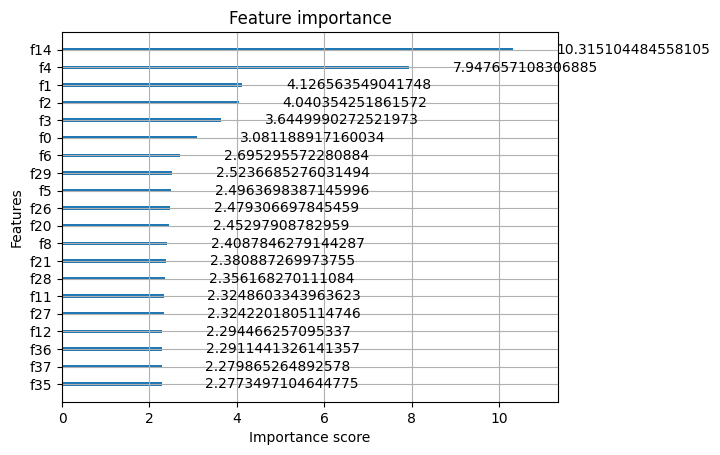

In [459]:
xgb.plot_importance(model, importance_type="gain", max_num_features=20)
plt.show()

In [460]:
training_data.columns

Index(['goal', 'under_pressure', 'location_x', 'location_y', 'location_z',
       'opposition_in_triangle', 'play_pattern_From Corner',
       'play_pattern_From Counter', 'play_pattern_From Free Kick',
       'play_pattern_From Goal Kick', 'play_pattern_From Keeper',
       'play_pattern_From Kick Off', 'play_pattern_From Throw In',
       'play_pattern_Other', 'play_pattern_Regular Play', 'pbody_part_Head',
       'pbody_part_Left Foot', 'pbody_part_Other', 'pbody_part_Right Foot',
       'position_name_Center Attacking Midfield', 'position_name_Center Back',
       'position_name_Center Defensive Midfield',
       'position_name_Center Forward', 'position_name_Goalkeeper',
       'position_name_Left Attacking Midfield', 'position_name_Left Back',
       'position_name_Left Center Back', 'position_name_Left Center Forward',
       'position_name_Left Center Midfield',
       'position_name_Left Defensive Midfield', 'position_name_Left Midfield',
       'position_name_Left Wing', 'pos

In [461]:
importance_df = pd.DataFrame.from_dict(
    model.get_booster().get_score(importance_type="gain"),
    orient="index",
    columns=["importance"]
).sort_values("importance", ascending=False)

print(importance_df.head(10))

     importance
f14   10.315104
f4     7.947657
f1     4.126564
f2     4.040354
f3     3.644999
f0     3.081189
f6     2.695296
f29    2.523669
f5     2.496370
f26    2.479307


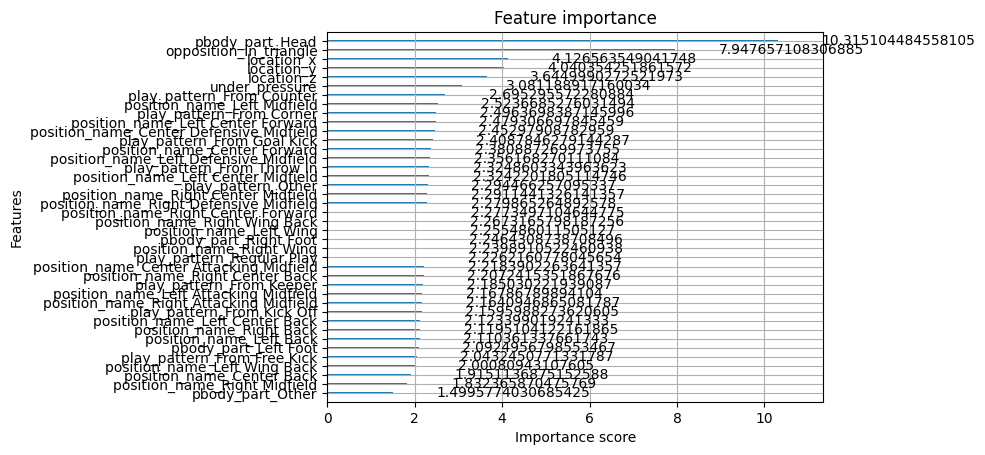

In [462]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="gain")
plt.show()


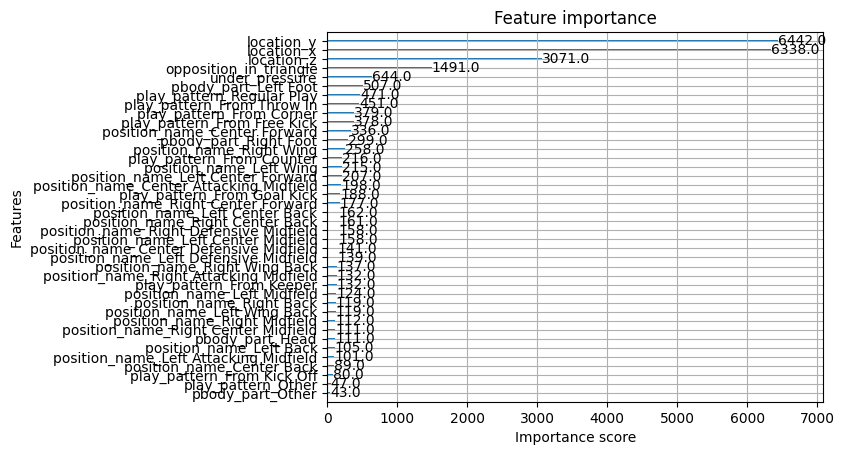

In [463]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="weight")
plt.show()


add physical metrics

In [464]:
shot_metrics_df.columns[shot_metrics_df.columns.str.contains("Distance")]

Index(['High Intensity (HI) Distance_now', 'High Intensity (HI) Distance_half',
       'High Intensity (HI) Distance_game',
       'High Speed Running (HSR) Distance_now',
       'High Speed Running (HSR) Distance_half',
       'High Speed Running (HSR) Distance_game', 'Running Distance_now',
       'Running Distance_half', 'Running Distance_game',
       'Sprinting Distance_now', 'Sprinting Distance_half',
       'Sprinting Distance_game', 'Total Distance_now', 'Total Distance_half',
       'Total Distance_game', 'High Intensity (HI) Distance_1_week',
       'High Speed Running (HSR) Distance_1_week', 'Running Distance_1_week',
       'Sprinting Distance_1_week', 'Total Distance_1_week',
       'High Intensity (HI) Distance_2_week',
       'High Speed Running (HSR) Distance_2_week', 'Running Distance_2_week',
       'Sprinting Distance_2_week', 'Total Distance_2_week',
       'High Intensity (HI) Distance_1_month',
       'High Speed Running (HSR) Distance_1_month', 'Running Distance_

In [465]:
shot_metrics_df.head()

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   
1           1  3c527d7b-6932-4190-8424-d1d3dcdd6a4d        191.0     1.0   
2           2  157da96f-2535-42f1-aaa4-273dc8ae2f12        368.0     1.0   
3           3  6a0404a3-2dd6-44d2-8c70-15bb2f858b82        535.0     1.0   
4           4  c06abd5a-b096-47eb-8352-6a5470db6d83        629.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   
1  00:05:11.529     5.0    11.0        11.0  1.023995       0.000000   
2  00:10:51.930    10.0    51.0        21.0  0.363535       0.000000   
3  00:14:17.334    14.0    17.0        27.0  1.067938       0.000000   
4  00:17:42.690    17.0    42.0        30.0  0.687717       0.047946   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   
1        0.034124    -0.034124           0.009421            0.009421   
2        0.204285    -0.204285           0.006885            0.006885   
3        0.095475    -0.095475           0.008562            0.008562   
4        0.076592    -0.028646           0.008465            0.008465   

   obv_against_net  obv_total_net  under_pressure  type_id type_name  \
0              0.0       0.027997               1     16.0      Shot   
1              0.0      -0.034124               0     16.0      Shot   
2              0.0      -0.204285               0     16.0      Shot   
3              0.0      -0.095475               0     16.0      Shot   
4              0.0      -0.028646               0     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   
1                36.0      Manchester City              7.0    From Goal Kick   
2                36.0      Manchester City              3.0    From Free Kick   
3                34.0              Burnley              4.0     From Throw In   
4                34.0              Burnley              3.0    From Free Kick   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   
1     36.0  Manchester City        88.4        46.0        0.00   
2     36.0  Manchester City       114.7        46.6        1.08   
3     34.0          Burnley       104.7        31.0        0.00   
4     34.0          Burnley       107.2        26.6        0.00   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   
1               207b5c5a-ff48-4534-a5e2-0f83b20df80a     3089.0   
2               764d5d53-f1a1-4d37-9f78-b549101782c5    23616.0   
3               200cd1f9-50d7-4e73-9143-106f764722f8   256682.0   
4               8ebcd607-df4e-495e-8062-9cbf005d4fdf    48335.0   

            player_name  position_id          position_name  statsbomb_xg  \
0         Erling Håland         23.0         Center Forward      0.166126   
1       Kevin De Bruyne         13.0  Right Center Midfield      0.023693   
2         Erling Håland         23.0         Center Forward      0.142146   
3         Luca Koleosho         17.0             Right Wing      0.083945   
4  Mohamed Zeki Amdouni         23.0         Center Forward      0.085442   

   goal  penalty   body_part  opposition_in_triangle   gameId  match_date  \
0   1.0      0.0   Left Foot                     1.0  3892755  2023-08-11   
1   0.0      0.0  Right Foot                     2.0  3892755  2023-08-11   
2   0.0      0.0  Right Foot                     1.0  3892755  2023-08-11   
3   0.0      0.0  Right Foot                     1.0  3892755  2023-08-11   
4   0.0      0.0   Left Foot                     1.0  3892755  2023-08-11   

   Count HI_now  Count

In [539]:
def workload_index(df, period):
    return (
        #df[f"Total Distance_{period}"] +#orig
        df[f"Running Distance_{period}"] +#
        3 * df[f"High Speed Running (HSR) Distance_{period}"] +#orig
        #3 * df[f"High Intensity (HI) Distance_{period}"] +
        5 * df[f"Sprinting Distance_{period}"] #orig
    )

# Example: compute workload index for different periods
for period in ["now", "half", "game", "1_week", "2_week", "1_month"]:
    shot_metrics_df[f"WI_{period}"] = workload_index(shot_metrics_df, period)

# Compute ACWR (Acute:Chronic Workload Ratio)
shot_metrics_df["ACWR"] = shot_metrics_df["WI_1_week"] / (shot_metrics_df["WI_1_month"]/4)
shot_metrics_df["ACWR"] = np.where(shot_metrics_df["ACWR"].isna(), 0,shot_metrics_df["ACWR"])
#shot_metrics_df["ACWR"] = np.where(shot_metrics_df["ACWR"]>0.9, shot_metrics_df["ACWR"]*0.8,shot_metrics_df["ACWR"])
shot_metrics_df["ACWR_bucket"] = pd.cut(
    shot_metrics_df["ACWR"],
    bins=[-float('inf'), 0.8, 1.3, 2, float('inf')], 
    labels=["Q1 (lowest)", "Q2", "Q3", "Q4"]
)
shot_metrics_df["ACWR_pos"] = np.where(shot_metrics_df["ACWR"]>0, 1,0)

In [540]:
shot_metrics_df.head()

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   
1           1  3c527d7b-6932-4190-8424-d1d3dcdd6a4d        191.0     1.0   
2           2  157da96f-2535-42f1-aaa4-273dc8ae2f12        368.0     1.0   
3           3  6a0404a3-2dd6-44d2-8c70-15bb2f858b82        535.0     1.0   
4           4  c06abd5a-b096-47eb-8352-6a5470db6d83        629.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   
1  00:05:11.529     5.0    11.0        11.0  1.023995       0.000000   
2  00:10:51.930    10.0    51.0        21.0  0.363535       0.000000   
3  00:14:17.334    14.0    17.0        27.0  1.067938       0.000000   
4  00:17:42.690    17.0    42.0        30.0  0.687717       0.047946   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   
1        0.034124    -0.034124           0.009421            0.009421   
2        0.204285    -0.204285           0.006885            0.006885   
3        0.095475    -0.095475           0.008562            0.008562   
4        0.076592    -0.028646           0.008465            0.008465   

   obv_against_net  obv_total_net  under_pressure  type_id type_name  \
0              0.0       0.027997               1     16.0      Shot   
1              0.0      -0.034124               0     16.0      Shot   
2              0.0      -0.204285               0     16.0      Shot   
3              0.0      -0.095475               0     16.0      Shot   
4              0.0      -0.028646               0     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   
1                36.0      Manchester City              7.0    From Goal Kick   
2                36.0      Manchester City              3.0    From Free Kick   
3                34.0              Burnley              4.0     From Throw In   
4                34.0              Burnley              3.0    From Free Kick   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   
1     36.0  Manchester City        88.4        46.0        0.00   
2     36.0  Manchester City       114.7        46.6        1.08   
3     34.0          Burnley       104.7        31.0        0.00   
4     34.0          Burnley       107.2        26.6        0.00   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   
1               207b5c5a-ff48-4534-a5e2-0f83b20df80a     3089.0   
2               764d5d53-f1a1-4d37-9f78-b549101782c5    23616.0   
3               200cd1f9-50d7-4e73-9143-106f764722f8   256682.0   
4               8ebcd607-df4e-495e-8062-9cbf005d4fdf    48335.0   

            player_name  position_id          position_name  statsbomb_xg  \
0         Erling Håland         23.0         Center Forward      0.166126   
1       Kevin De Bruyne         13.0  Right Center Midfield      0.023693   
2         Erling Håland         23.0         Center Forward      0.142146   
3         Luca Koleosho         17.0             Right Wing      0.083945   
4  Mohamed Zeki Amdouni         23.0         Center Forward      0.085442   

   goal  penalty   body_part  opposition_in_triangle   gameId  match_date  \
0   1.0      0.0   Left Foot                     1.0  3892755  2023-08-11   
1   0.0      0.0  Right Foot                     2.0  3892755  2023-08-11   
2   0.0      0.0  Right Foot                     1.0  3892755  2023-08-11   
3   0.0      0.0  Right Foot                     1.0  3892755  2023-08-11   
4   0.0      0.0   Left Foot                     1.0  3892755  2023-08-11   

   Count HI_now  Count

In [541]:
shot_metrics_df["ACWR"].mean()

np.float64(1.2241821842570726)

<Axes: ylabel='Density'>

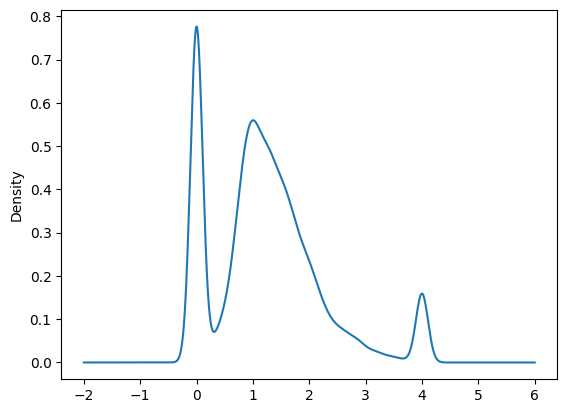

In [542]:
shot_metrics_df["ACWR"].plot.density()

In [543]:
len(shot_metrics_df[shot_metrics_df["ACWR"]==0])

12686

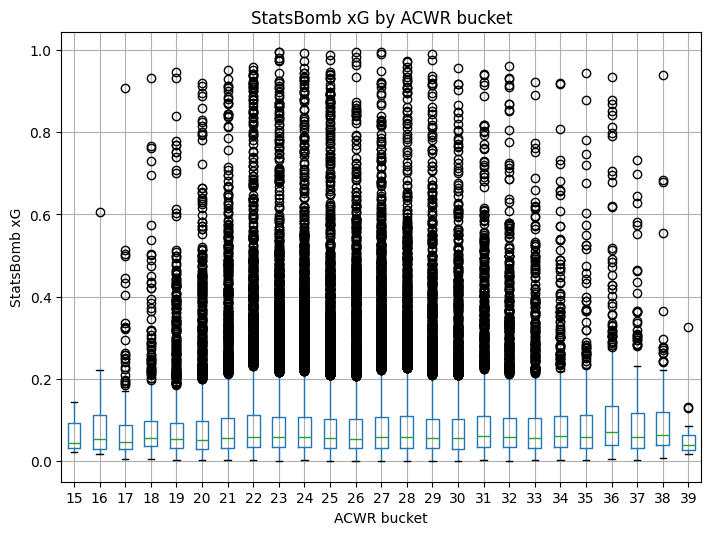

In [544]:
import plotly.express as px
df = shot_metrics_df.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="statsbomb_xg", by="age", ax=ax)

# Beautify
ax.set_title("StatsBomb xG by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("StatsBomb xG")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

In [545]:
ML_data= shot_metrics_df[[
    "age","team_name","goal", "under_pressure","play_pattern_name","body_part" ,"location_x","location_y","location_z","opposition_in_triangle",
    'ACWR_bucket'#'WI_now', 'WI_game', 'WI_1_week','WI_2_week','WI_1_month',
    #   'ACWR',,
    #    'ACWR_pos'
    #"position_name",
    #"Count HI_1_week", "Count HSR_1_week", "Count High Acceleration_1_week", "Count High Deceleration_1_week", 
    #"Count Medium Acceleration_1_week", "Count Medium Deceleration_1_week", "Count Sprint_1_week", 
    #"High Intensity (HI) Distance_1_week", "High Speed Running (HSR) Distance_1_week", "M/min_1_week", 
    #"Max Speed_1_week", "Running Distance_1_week", "Sprinting Distance_1_week", "Total Distance_1_week", 
    #"Count HI_2_week", "Count HSR_2_week", "Count High Acceleration_2_week", "Count High Deceleration_2_week", 
    #"Count Medium Acceleration_2_week", "Count Medium Deceleration_2_week", "Count Sprint_2_week", 
    #"High Intensity (HI) Distance_2_week", "High Speed Running (HSR) Distance_2_week", "M/min_2_week", 
    #"Max Speed_2_week", "Running Distance_2_week", "Sprinting Distance_2_week", "Total Distance_2_week", 
    #"Count HI_1_month", "Count HSR_1_month", "Count High Acceleration_1_month", "Count High Deceleration_1_month", 
    #"Count Medium Acceleration_1_month", "Count Medium Deceleration_1_month", "Count Sprint_1_month", 
    #"High Intensity (HI) Distance_1_month", "High Speed Running (HSR) Distance_1_month", "M/min_1_month", 
    #"Max Speed_1_month", "Running Distance_1_month", "Sprinting Distance_1_month", "Total Distance_1_month"
]]
play_pattern_onehot = pd.get_dummies(ML_data.play_pattern_name, 
    prefix="play_pattern")#, dtype=float)
body_part_onehot = pd.get_dummies(ML_data.body_part, 
    prefix="pbody_part")#, dtype=float)
#position_name_onehot = pd.get_dummies(ML_data.position_name, 
#    prefix="position_name")#, dtype=float)
acwr_onehot = pd.get_dummies(ML_data.ACWR_bucket, 
    prefix="acwr")#, dtype=float)
ML_data = pd.concat([ML_data,play_pattern_onehot,body_part_onehot,acwr_onehot ], axis=1).drop(["play_pattern_name","body_part",'ACWR_bucket'],axis=1)
training_data =  ML_data[~ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)
test_data =  ML_data[ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)

just players with over 100 shots?

In [546]:
X_train_raw = training_data.drop("goal", axis=1).astype(float)
y_train_raw = training_data["goal"].astype(int)

X_test = np.array(test_data.drop("goal", axis=1).astype(float))
y_test = np.array(test_data["goal"].astype(int))

#scaler = StandardScaler()
#model = scaler.fit(X_train_raw)
#X_scaled = model.transform(X_train_raw)
#X_test = model.transform(X_test_raw)
X_train, X_val, y_train, y_val = train_test_split(
    np.array(X_train_raw), np.array(y_train_raw), test_size=0.25, random_state=123
)

In [547]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score


# Define features and target
neg, pos = np.bincount(y_train)
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")


# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=1000,       # number of trees
    max_depth=5,           # depth of each tree
    learning_rate=0.05,     # step size shrinkage
    subsample=0.8,        # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42,
    use_label_encoder=False,
    objective="binary:logistic",
    eval_metric="logloss",
    #scale_pos_weight=4  # avoids warning about label encoder
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Evaluation
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

scale_pos_weight = 8.43


c:\Users\conny\OneDrive\Documents\Projects\Hudl_Performance\Hudl_Performance_Insights_2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:08:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.903
ROC AUC: 0.754


In [548]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[8166,   95],
       [ 799,  131]])

In [549]:
confusion_matrix(statsbomb_actual,statsbomb_test )

array([[8206,   55],
       [ 794,  136]])

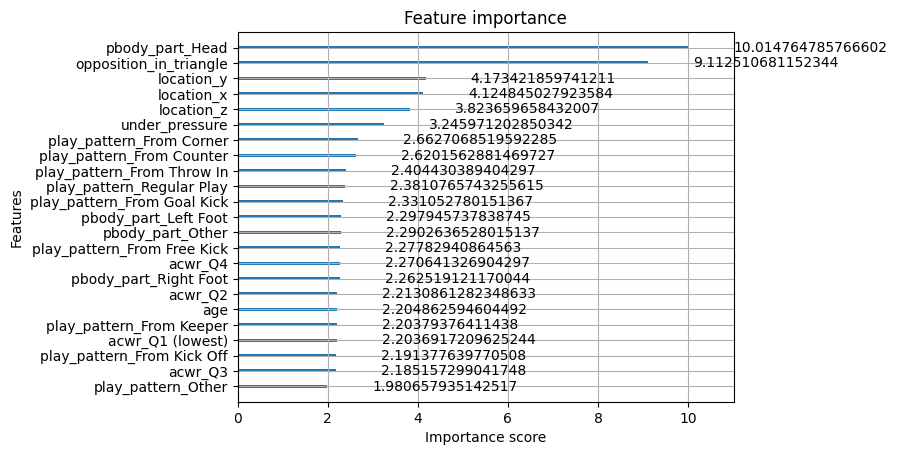

In [550]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="gain")
plt.show()

In [551]:
importance_df = pd.DataFrame.from_dict(
    model.get_booster().get_score(importance_type="gain"),
    orient="index",
    columns=["importance"]
).sort_values("importance", ascending=False)

print(importance_df.head(30))

                             importance
pbody_part_Head               10.014765
opposition_in_triangle         9.112511
location_y                     4.173422
location_x                     4.124845
location_z                     3.823660
under_pressure                 3.245971
play_pattern_From Corner       2.662707
play_pattern_From Counter      2.620156
play_pattern_From Throw In     2.404430
play_pattern_Regular Play      2.381077
play_pattern_From Goal Kick    2.331053
pbody_part_Left Foot           2.297946
pbody_part_Other               2.290264
play_pattern_From Free Kick    2.277829
acwr_Q4                        2.270641
pbody_part_Right Foot          2.262519
acwr_Q2                        2.213086
age                            2.204863
play_pattern_From Keeper       2.203794
acwr_Q1 (lowest)               2.203692
play_pattern_From Kick Off     2.191378
acwr_Q3                        2.185157
play_pattern_Other             1.980658


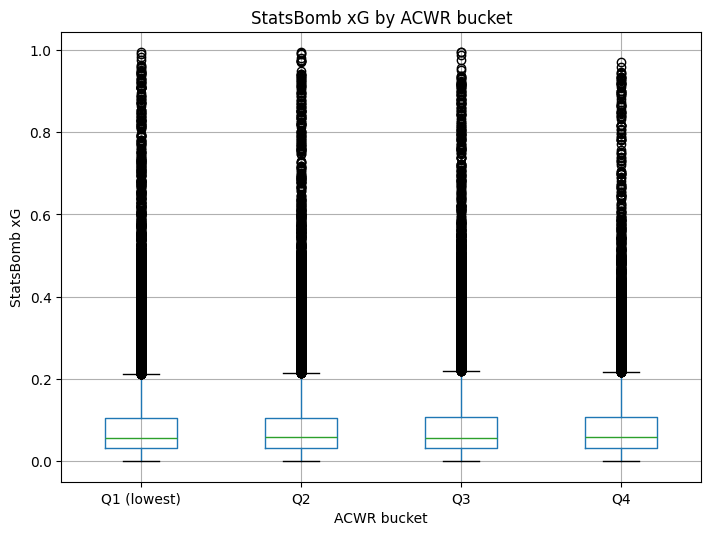

In [552]:
import plotly.express as px
df = shot_metrics_df.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="statsbomb_xg", by="ACWR_bucket", ax=ax)

# Beautify
ax.set_title("StatsBomb xG by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("StatsBomb xG")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

if not better explanation maybe different shots?

does match by match tiredness reduce shot number (quality) in next game? avg xg per shot?

match_date player avg_shot_xg (max ).str.endswith(('1_week', '2_week', '1_month')

In [553]:
shot_metrics_df.head(1)

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   

   obv_against_net  obv_total_net  under_pressure  type_id type_name  \
0              0.0       0.027997               1     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   

     player_name  position_id   position_name  statsbomb_xg  goal  penalty  \
0  Erling Håland         23.0  Center Forward      0.166126   1.0      0.0   

   body_part  opposition_in_triangle   gameId  match_date  Count HI_now  \
0  Left Foot                     1.0  3892755  2023-08-11           1.2   

   Count HI_half  Count HI_game  Count HSR_now  Count HSR_half  \
0            0.0            0.0            1.0             0.0   

   Count HSR_game  Count High Acceleration_now  Count High Acceleration_half  \
0             0.0                          0.2                           0.0   

   Count High Acceleration_game  Count High Deceleration_now  \
0                           0.0                          0.4   

   Count High Deceleration_half  Count High Deceleration_game  \
0                           0.0                           0.0   

   Count Medium Acceleration_now  Count Medium Acceleration_half  \
0                            6.8                             0.0   

   Count Medium Acceleration_game  Count Medium Deceleration_now  \
0                             0.0                            4.4   

   Count Medium Deceleration_half  Count Medium Deceleration_game  \
0                             0.0                             0.0   

   Count Sprint_now  Count Sprint_half  Count Sprint_game  \
0               0.2                0.0                0.0   

   High Intensity (HI) Distance_now  High Intensity (HI) Distance_half  \
0                         17.017352                                0.0   

   High Intensity (HI) Distance_game  High Speed Running (HSR) Distance_now  \
0                                0.0                              15.196193   

   High Speed Running (HSR) Distance_half  \
0                                     0.0   

   High Speed Running (HSR) Distance_game  M/min_now  M/min_half  M/min_game  \
0                                     0.0  20.433466         0.0         0.0   

   Max Speed_now  Max Speed_half  Max Speed_game  Running Distance_now  \
0       5.187833             0.0             0.0             37.352316   

   Running Distance_half  Running Distance_game  Sprinting Distance_now  \
0                    0.0                    0.0                1.821159   

   Sprinting Distance_half  Sprinting Distance_game  Total Distance_now  \
0                      0.0                      0.0          306.501986   

   Total Distance_half  Total Distance_game  Count HI_1_week  \
0                  0.0                  0.0             48.0   

   Count HSR_1_week  Count High Acceleration_1_week  \
0              30.0                            30.0   

   Count High Deceleration_1_week  Count Medium Acceleration_1_week  \
0                            25.0                             141.0   

   Count Medium Deceleration_1_week  Count Sprint_1_week  \
0                             110.0                 18.0   

   High Intensity (HI) Distance_1_week  \
0                        

In [554]:
pattern_cols = shot_metrics_df.filter(regex='_(1_week|2_week|1_month)$').columns
#pattern_cols = shot_metrics_df.filter(regex='ACWR').columns
specific_cols = ["player_id", "match_date", "over_xg","ACWR","ACWR_pos","ACWR_bucket"]#statsbomb_xg


In [555]:
shot_metrics_df[specific_cols + list(pattern_cols)]

player_id  match_date   over_xg      ACWR  ACWR_pos  ACWR_bucket  \
0        23616.0  2023-08-11  0.833874  4.000000         1           Q4   
1         3089.0  2023-08-11 -0.023693  4.000000         1           Q4   
2        23616.0  2023-08-11 -0.142146  4.000000         1           Q4   
3       256682.0  2023-08-11 -0.083945  4.000000         1           Q4   
4        48335.0  2023-08-11 -0.085442  4.000000         1           Q4   
...          ...         ...       ...       ...       ...          ...   
61649    33281.0  2025-05-21 -0.052227  0.000000         0  Q1 (lowest)   
61650     3336.0  2025-05-21 -0.032896  1.648422         1           Q3   
61651   151931.0  2025-05-21 -0.024010  0.000000         0  Q1 (lowest)   
61652     3382.0  2025-05-21 -0.093079  0.991829         1           Q2   
61653     5539.0  2025-05-21 -0.039709  2.589001         1           Q4   

       Count HI_1_week  Count HSR_1_week  Count High Acceleration_1_week  \
0                 48.0              30.0                            30.0   
1                 18.0              17.0                             3.0   
2                 48.0              30.0                            30.0   
3                 55.0              46.0                            27.0   
4                 46.0              37.0                            15.0   
...                ...               ...                             ...   
61649              0.0               0.0                             0.0   
61650             41.0              28.0                            24.0   
61651              0.0               0.0                             0.0   
61652             35.0              29.0                            16.0   
61653             52.0              39.0                            24.0   

       Count High Deceleration_1_week  Count Medium Acceleration_1_week  \
0                                25.0                             141.0   
1                                 6.0                              51.0   
2                                25.0                             141.0   
3                                43.0                             179.0   
4                                20.0                             162.0   
...                               ...                               ...   
61649                             0.0                               0.0   
61650                            31.0                             179.0   
61651                             0.0                               0.0   
61652                            18.0                             156.0   
61653                            13.0                             155.0   

       Count Medium Deceleration_1_week  Count Sprint_1_week  \
0                                 110.0                 18.0   
1                                  41.0                  1.0   
2                                 110.0                 18.0   
3                                 141.0                  9.0   
4                                 129.0                  9.0   
...                                 ...                  ...   
61649                               0.0                  0.0   
61650                             143.0                 13.0   
61651                               0.0                  0.0   
61652                             117.0                  6.0   
61653                             147.0                 13.0   

       High Intensity (HI) Distance_1_week  \
0                               836.038147   
1                               171.572998   
2                               836.038147   
3                               639.982910   
4                               531.848816   
...                                    ...   
61649                             0.000000   
61650                           649.504211   
61651                             0.000000   
61652                           398.502380   
61653            

In [556]:
shots_by_player_match = shot_metrics_df[specific_cols + list(pattern_cols)]#.groupby(["player_id","match_date"],as_index=False).min()

In [557]:
#shots_by_player_match = shot_metrics_df[["player_id", "match_date", "statsbomb_xg","ACWR","ACWR_pos","ACWR_bucket"]]

In [558]:
shots_by_player_match.columns

Index(['player_id', 'match_date', 'over_xg', 'ACWR', 'ACWR_pos', 'ACWR_bucket',
       'Count HI_1_week', 'Count HSR_1_week', 'Count High Acceleration_1_week',
       'Count High Deceleration_1_week', 'Count Medium Acceleration_1_week',
       'Count Medium Deceleration_1_week', 'Count Sprint_1_week',
       'High Intensity (HI) Distance_1_week',
       'High Speed Running (HSR) Distance_1_week', 'M/min_1_week',
       'Max Speed_1_week', 'Running Distance_1_week',
       'Sprinting Distance_1_week', 'Total Distance_1_week', 'Count HI_2_week',
       'Count HSR_2_week', 'Count High Acceleration_2_week',
       'Count High Deceleration_2_week', 'Count Medium Acceleration_2_week',
       'Count Medium Deceleration_2_week', 'Count Sprint_2_week',
       'High Intensity (HI) Distance_2_week',
       'High Speed Running (HSR) Distance_2_week', 'M/min_2_week',
       'Max Speed_2_week', 'Running Distance_2_week',
       'Sprinting Distance_2_week', 'Total Distance_2_week',
       'Count HI_1

In [559]:
group_col = ["player_id","match_date"]#
mean_col = "over_xg"#'statsbomb_xg'

other_cols = [col for col in shots_by_player_match.columns if col not in group_col]

agg_dict = {mean_col: ['mean', 'sum', 'count']}
agg_dict.update({col: 'max' for col in other_cols if col != mean_col})

shots_by_player_match = shots_by_player_match.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
shots_by_player_match.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in shots_by_player_match.columns]



In [560]:
#shot_metrics_df[(shot_metrics_df.player_id==106904.0) |(shot_metrics_df.player_id==199774.0)].to_csv("what.csv")

Maybe take just strikers with over 30 shots or 100 or whatever

In [561]:
good_shooters = shot_metrics_df[["player_id","statsbomb_xg"]].groupby("player_id",as_index=False).count().sort_values(by="statsbomb_xg", ascending=False)
good_shooters = good_shooters[good_shooters["statsbomb_xg"]>1]
shots_by_player_match_good =  shots_by_player_match[shots_by_player_match["player_id"].isin(good_shooters.player_id)]
good_shooters

player_id  statsbomb_xg
854     10955.0           292
125      3531.0           258
1284    23616.0           256
1993    39461.0           234
2366    52129.0           228
...         ...           ...
1921    38784.0             2
1994    39482.0             2
3218   425765.0             2
3223   427105.0             2
3231   431133.0             2

[2914 rows x 2 columns]

In [562]:
#shot_metrics_df.to_csv("lessee.csv")

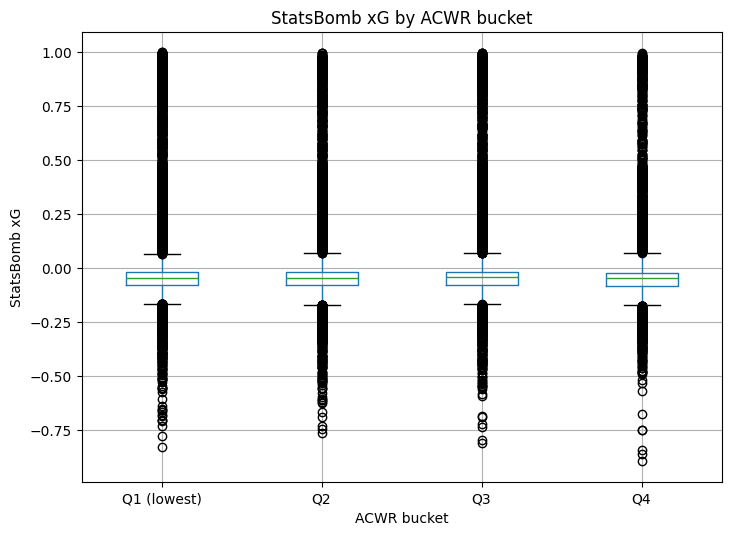

In [563]:
import plotly.express as px
df = shots_by_player_match.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="over_xg_mean", by="ACWR_bucket_max", ax=ax)

# Beautify
ax.set_title("StatsBomb xG by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("StatsBomb xG")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

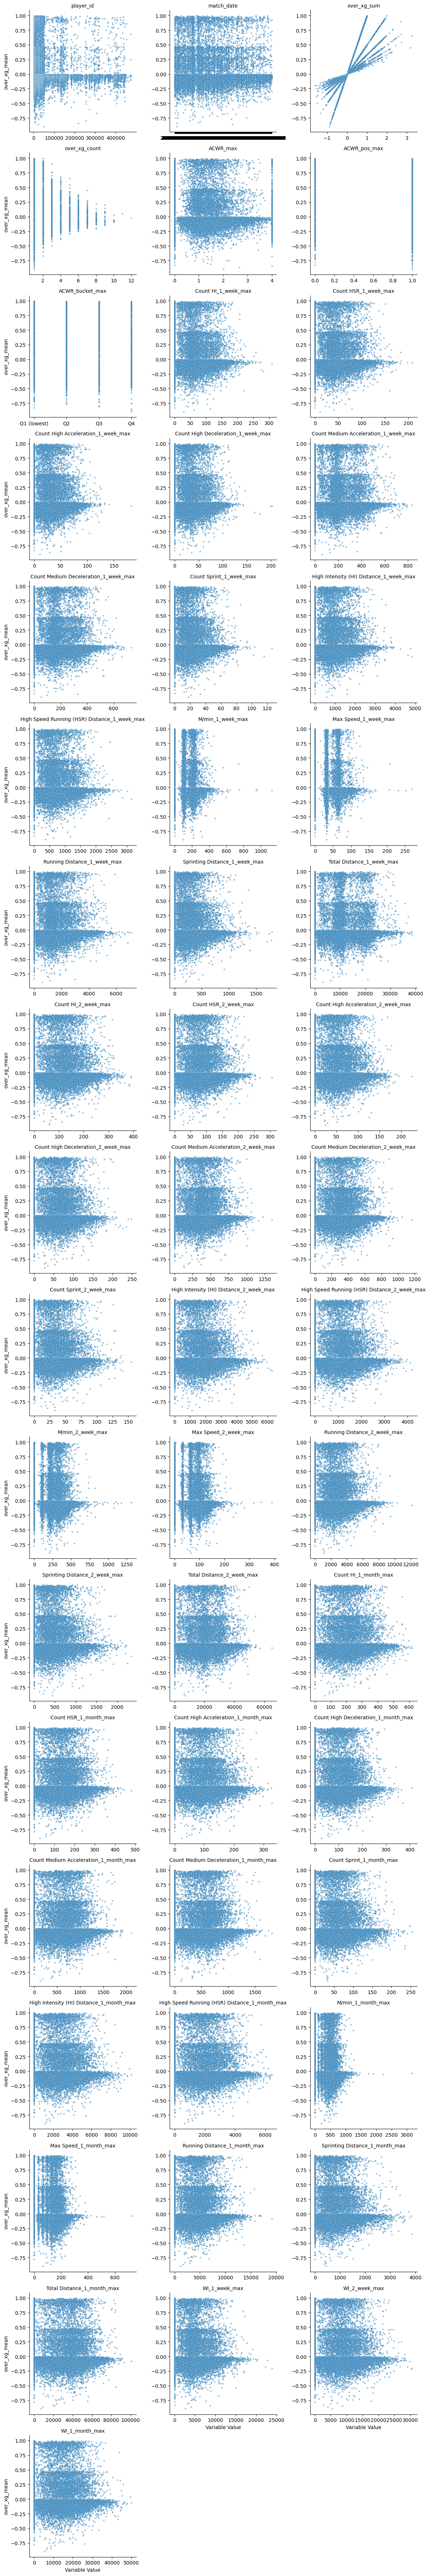

In [564]:
target = "over_xg_mean"

# Select the variables you want to plot against statsbomb_xg_mean
# Exclude the target itself and any other columns you don't want to plot
plot_variables = [col for col in shots_by_player_match.columns 
                  if col != target and col not in ['team_id']]  # player_id, 'player_name'

df_melted = shots_by_player_match.melt(id_vars=[target], 
                                      value_vars=plot_variables,
                                      var_name="variable", 
                                      value_name="x_value")

g = sns.FacetGrid(df_melted, col="variable", col_wrap=3, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x="x_value", y=target, alpha=0.5, s=10)
g.set_titles(col_template="{col_name}")
g.set_axis_labels(x_var="Variable Value", y_var=target)
plt.tight_layout()
plt.show()

In [565]:
import seaborn as sns
import matplotlib.pyplot as plt

target = "statsbomb_xg_count"
df_melted = shots_by_player_match_good.melt(id_vars=target, var_name="variable", value_name="value")

g = sns.FacetGrid(df_melted, col="variable", col_wrap=3, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x=target, y="value", alpha=0.5, s=10)
g.set_titles(col_template="{col_name}")
plt.show()


KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['statsbomb_xg_count']"

so we have:
looked at individual shots to xg
match level statistics
including just top players

to do:
do tired players exceed / underperform their xg (maybe plot underperformance by tiredness by age)
within games: does it get worse as game goes on (quality/quantity)
within team, does shot quality get worse as fatigue builds (dont have stats for whole team currently, just shooter)


In [ ]:
shot_metrics_df.head(1)

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   

   obv_against_net  obv_total_net  under_pressure  type_id type_name  \
0              0.0       0.027997               1     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   

     player_name  position_id   position_name  statsbomb_xg  goal  penalty  \
0  Erling Håland         23.0  Center Forward      0.166126   1.0      0.0   

   body_part  opposition_in_triangle   gameId  match_date  Count HI_now  \
0  Left Foot                     1.0  3892755  2023-08-11           1.2   

   Count HI_half  Count HI_game  Count HSR_now  Count HSR_half  \
0            0.0            0.0            1.0             0.0   

   Count HSR_game  Count High Acceleration_now  Count High Acceleration_half  \
0             0.0                          0.2                           0.0   

   Count High Acceleration_game  Count High Deceleration_now  \
0                           0.0                          0.4   

   Count High Deceleration_half  Count High Deceleration_game  \
0                           0.0                           0.0   

   Count Medium Acceleration_now  Count Medium Acceleration_half  \
0                            6.8                             0.0   

   Count Medium Acceleration_game  Count Medium Deceleration_now  \
0                             0.0                            4.4   

   Count Medium Deceleration_half  Count Medium Deceleration_game  \
0                             0.0                             0.0   

   Count Sprint_now  Count Sprint_half  Count Sprint_game  \
0               0.2                0.0                0.0   

   High Intensity (HI) Distance_now  High Intensity (HI) Distance_half  \
0                         17.017352                                0.0   

   High Intensity (HI) Distance_game  High Speed Running (HSR) Distance_now  \
0                                0.0                              15.196193   

   High Speed Running (HSR) Distance_half  \
0                                     0.0   

   High Speed Running (HSR) Distance_game  M/min_now  M/min_half  M/min_game  \
0                                     0.0  20.433466         0.0         0.0   

   Max Speed_now  Max Speed_half  Max Speed_game  Running Distance_now  \
0       5.187833             0.0             0.0             37.352316   

   Running Distance_half  Running Distance_game  Sprinting Distance_now  \
0                    0.0                    0.0                1.821159   

   Sprinting Distance_half  Sprinting Distance_game  Total Distance_now  \
0                      0.0                      0.0          306.501986   

   Total Distance_half  Total Distance_game  Count HI_1_week  \
0                  0.0                  0.0              0.0   

   Count HSR_1_week  Count High Acceleration_1_week  \
0               0.0                             0.0   

   Count High Deceleration_1_week  Count Medium Acceleration_1_week  \
0                             0.0                               0.0   

   Count Medium Deceleration_1_week  Count Sprint_1_week  \
0                               0.0                  0.0   

   High Intensity (HI) Distance_1_week  \
0                        

In [566]:
player_buckets = shot_metrics_df[["player_id","ACWR_bucket","over_xg"]].groupby(["player_id","ACWR_bucket"],as_index=False).mean()

C:\Users\conny\AppData\Local\Temp\ipykernel_9320\783131950.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  player_buckets = shot_metrics_df[["player_id","ACWR_bucket","over_xg"]].groupby(["player_id","ACWR_bucket"],as_index=False).mean()


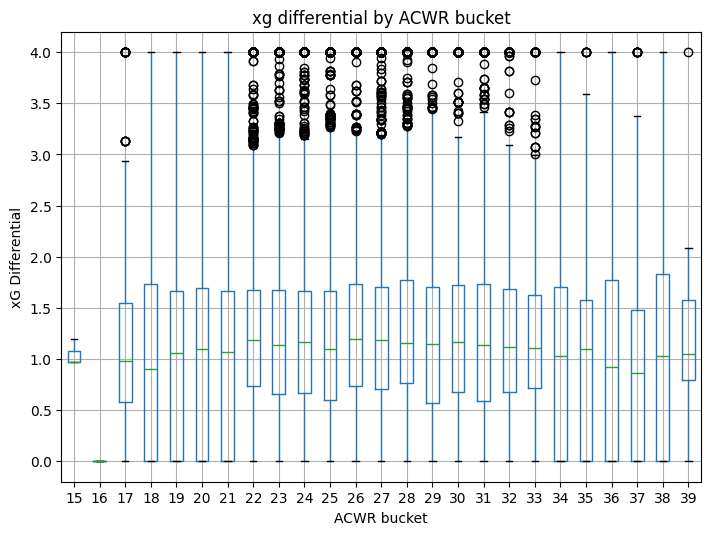

In [567]:
import plotly.express as px
df = shot_metrics_df.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="ACWR", by="age", ax=ax)

# Beautify
ax.set_title("xg differential by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("xG Differential")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

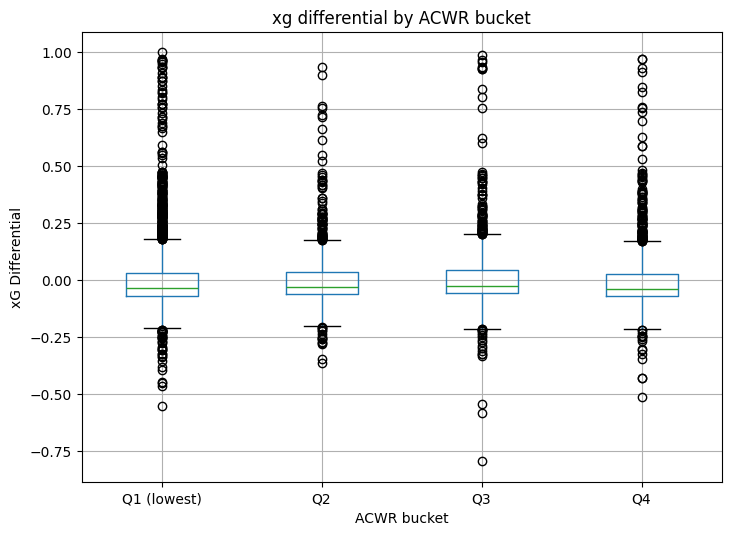

In [568]:
import plotly.express as px
df = player_buckets.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="over_xg", by="ACWR_bucket", ax=ax)

# Beautify
ax.set_title("xg differential by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("xG Differential")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

first slides: does fatigue influence xg: NO
next slides: ok it doesn't affect quality of shot, does it affect likelihood of being converted? this doesn't make sense



on average a shot in Q1 is 0.06 and a shot in Q4 is 0.007 less likely to go in 

the risk is greater when a player is undercooked

In [569]:
df_wide = player_buckets.pivot(index='player_id', columns='ACWR_bucket', values='over_xg').fillna(0).reset_index()
df_wide.columns.name = None

In [570]:
df_wide.quantile([0,0.25,0.5,0.75,1])

player_id  Q1 (lowest)        Q2        Q3        Q4
0.00     2935.0    -0.554754 -0.363781 -0.796298 -0.516678
0.25    10586.0    -0.063805 -0.005918 -0.007432 -0.031218
0.50    31064.5    -0.030274  0.000000  0.000000  0.000000
0.75   105506.0     0.006663  0.000000  0.000000  0.000000
1.00   476247.0     0.997144  0.930800  0.984875  0.968444

In [571]:
df_wide.mean()

player_id      86083.929257
Q1 (lowest)        0.002800
Q2                -0.001543
Q3                 0.000854
Q4                -0.002855
dtype: float64